### Procesamiento de data para identificar periodos análogos

### Librerias

In [28]:
! pip install plotly

In [29]:
import pandas as pd
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import glob
from pathlib import PureWindowsPath
from datetime import datetime
import re
import warnings
import os
import xlrd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import plotly.express as px

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist


from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics import silhouette_score, make_scorer


warnings.filterwarnings("ignore")
# set the max columns to none
pd.set_option('display.max_columns', None)

En esta primera parte, se replican los resultados obtenidos del análisis de conglomerados para cada una de las variables utilizando el aplicativo Infostat. Para cada variable, se realiza un análisis de conglomerados aplicando el método de clustering jerárquico, sin normalizar los datos y utilizando el método de enlace promedio. Posteriormente, de forma visual, se identifican los periodos más semejantes.

In [3]:
### Cambiar estructura de tablas

def estructura_df(df):
    df= df.copy()
    month_names = {1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril', 5: 'Mayo', 6: 'Junio'}
    df['Mes'] =df['Mes'].map(month_names)

    df = df.set_index('Mes').transpose()
    ordered_columns = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio']
    df= df[ordered_columns]
    df = df.reset_index()
    df = df.rename(columns={'index': 'Año'})
    df.index.name = None
    df.columns.name = None
   
    return df

####################################
# Data lluvia
####################################

In [81]:
df_lluvia=pd.read_excel("D:\\OneDrive - CGIAR\\Proyectos\\AgriLAC-ICC\\Analytics\\Datos para estimación años análogos junio 2024.xlsx", sheet_name="Datos lluvias")
df_lluvia=estructura_df(df_lluvia)
df_lluvia.head()

,Año,Enero,Febrero,Marzo,Abril,Mayo,Junio
0,1998,0.0,0.0,0.0,4.8,23.8,84.8
1,1999,0.4,49.6,47.8,294.0,494.2,662.4
2,2000,12.0,12.0,7.4,21.4,319.4,405.4
3,2001,1.4,68.0,25.2,91.8,501.8,633.8
4,2002,27.0,6.8,44.4,46.8,389.0,425.5


In [70]:
#### tabla formato largo
df_melted = df_lluvia.melt(id_vars='Año', var_name='Mes', value_name='Lluvia')
df_melted

,Año,Mes,Lluvia
0,1998,Enero,0.0
1,1999,Enero,0.4
2,2000,Enero,12.0
3,2001,Enero,1.4
4,2002,Enero,27.0
...,...,...,...
184,2020,Cluster,1.0
185,2021,Cluster,1.0
186,2022,Cluster,1.0
187,2023,Cluster,1.0


####################################
### Comportamiento de la lluvia por periodo
####################################

In [66]:

meses_orden = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio"]
df_melted['Mes'] = pd.Categorical(df_melted['Mes'], categories=meses_orden, ordered=True)

# Graficar la serie de tiempo
fig = px.line(df_melted, x='Mes', y='Lluvia', color='Año',
              labels={'Mes': 'Mes', 'Lluvia': 'Lluvia (mm)', 'Año': 'Año'},
              title='Comportamiento de Lluvias por Año')

fig.show()

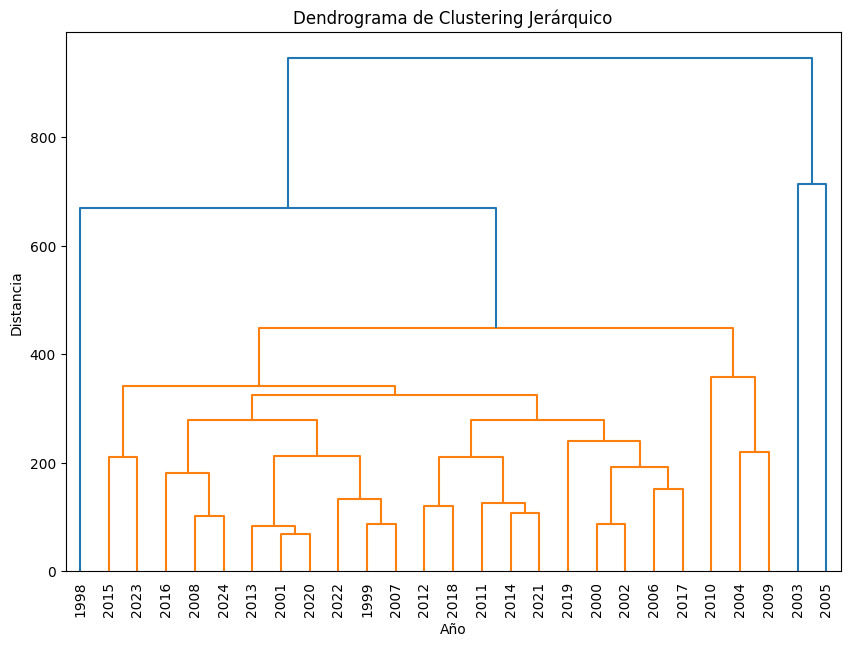

,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5,Cluster6
0,1999,2004.0,2010.0,1998.0,2003.0,2005.0
1,2000,2009.0,NaN,NaN,NaN,NaN
2,2001,NaN,NaN,NaN,NaN,NaN
3,2002,NaN,NaN,NaN,NaN,NaN
4,2006,NaN,NaN,NaN,NaN,NaN
5,2007,NaN,NaN,NaN,NaN,NaN
6,2008,NaN,NaN,NaN,NaN,NaN
7,2011,NaN,NaN,NaN,NaN,NaN
8,2012,NaN,NaN,NaN,NaN,NaN
9,2013,NaN,NaN,NaN,NaN,NaN


In [72]:
# Normalizar los datos (opcional, pero recomendable)
df_scaled = df_lluvia.copy()
#df_scaled.iloc[:, 1:] = (df_scaled.iloc[:, 1:] - df_scaled.iloc[:, 1:].mean()) / df_scaled.iloc[:, 1:].std()

# Calcular la matriz de distancias
dist_matrix = pdist(df_scaled.iloc[:, 1:], metric='euclidean')

# Aplicar el algoritmo de clustering jerárquico
Z = linkage(dist_matrix, method='average')

# Dibujar el dendrograma
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=df_lluvia['Año'].values, leaf_rotation=90)
plt.title('Dendrograma de Clustering Jerárquico')
plt.xlabel('Año')
plt.ylabel('Distancia')
plt.show()




#  criterio para el número máximo de clusters
max_clusters = 6 # máximo de 5 clusters
clusters = fcluster(Z, max_clusters, criterion='maxclust')

df_lluvia['Cluster'] = clusters

df_lluvia[['Año', 'Cluster']]


# Agrupar los años por cada cluster
cluster_groups = df_lluvia.groupby('Cluster')['Año'].apply(list).reset_index()


cluster_results = {}
for index, row in cluster_groups.iterrows():
    cluster_results[f'Cluster{row["Cluster"]}'] = row['Año']

lluvia= pd.DataFrame(dict([(k, pd.Series(v)) for k, v in cluster_results.items()]))


lluvia

In [88]:
# Transformar tabla para obtener columnas "Año" y "Cluster"
clusters_melted = lluvia.melt(var_name='ClusterLluvia', value_name='Año').dropna().reset_index(drop=True)


### Resultado por el programa de  Infostat (lluvia) 6 clusters

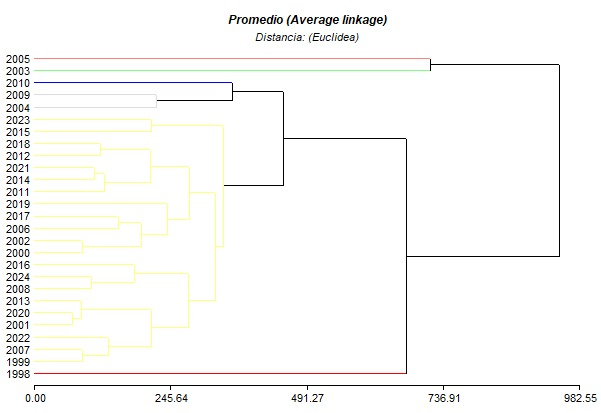

In [97]:
df_lluvia_clusters = df_lluvia.merge(clusters_melted, on='Año', how='left')
df_lluvia_clusters.head()

,Año,Enero,Febrero,Marzo,Abril,Mayo,Junio,ClusterLluvia
0,1998,0.0,0.0,0.0,4.8,23.8,84.8,Cluster4
1,1999,0.4,49.6,47.8,294.0,494.2,662.4,Cluster1
2,2000,12.0,12.0,7.4,21.4,319.4,405.4,Cluster1
3,2001,1.4,68.0,25.2,91.8,501.8,633.8,Cluster1
4,2002,27.0,6.8,44.4,46.8,389.0,425.5,Cluster1


In [90]:
df_melted = df_lluvia_clusters.melt(id_vars=['Año', 'ClusterLluvia'], 
                           var_name='Mes', 
                           value_name='Lluvia')
df_melted

,Año,ClusterLluvia,Mes,Lluvia
0,1998,Cluster4,Enero,0.0
1,1999,Cluster1,Enero,0.4
2,2000,Cluster1,Enero,12.0
3,2001,Cluster1,Enero,1.4
4,2002,Cluster1,Enero,27.0
...,...,...,...,...
157,2020,Cluster1,Junio,594.0
158,2021,Cluster1,Junio,447.8
159,2022,Cluster1,Junio,545.6
160,2023,Cluster1,Junio,474.2


In [91]:

meses_orden = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio"]
df_melted['Mes'] = pd.Categorical(df_melted['Mes'], categories=meses_orden, ordered=True)

# Graficar la serie de tiempo
fig = px.line(df_melted, x='Mes', y='Lluvia', color='ClusterLluvia', 
              labels={'Mes': 'Mes', 'Lluvia': 'Lluvia (mm)', 'ClusterLluvia': 'Cluster'},
              title='Comportamiento de Lluvias por Cluster')

fig.show()

In [92]:

meses_orden = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio"]
df_melted['Mes'] = pd.Categorical(df_melted['Mes'], categories=meses_orden, ordered=True)

# Graficar la serie de tiempo
fig = px.box(df_melted, x='Mes', y='Lluvia', color='ClusterLluvia', 
              labels={'Mes': 'Mes', 'Lluvia': 'Lluvia (mm)', 'ClusterLluvia': 'Cluster'},
              title='Comportamiento de Lluvias por Cluster')

fig.show()

#### Interpretación

* Cluster 1: 1999,2000,2001,2002,2006,2007,2008,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
* Cluster 2: 2004,2009
* Cluster 3: 2010
* Cluster 4: 1998
* Cluster 5: 2003
* Cluster 6: 2005

### Caracterización de clusters lluvia

* Cluster 1: Es el más grande, abarcando la mayoría de los años desde 1999 hasta 2024. Representa el patrón de lluvia más común o "normal" para la región.
* Cluster 2 (2004, 2009): Muestra un patrón de lluvia distinto, con un pico más pronunciado en mayo comparado con el Cluster 1.
* Cluster 3 (2010): Presenta el segundo nivel más alto de precipitación, especialmente notable en abril y mayo.
* Cluster 4 (1998): Año con el patrón de lluvia más bajo y constante a lo largo de los meses.
* Cluster 5 (2003): el cluster con la mayor cantidad de lluvia, mostrando un pico muy pronunciado en mayo y manteniendo niveles altos en junio. Representa el año con el patrón de precipitación más extremo.
* Cluster 6 (2005): Muestra un patrón intermedio, con un aumento significativo en mayo pero no tan extremo como los Clusters 3 y 5.

####################################
# Data Atlantico
####################################

In [98]:
df_atlantico=pd.read_excel("D:\\OneDrive - CGIAR\\Proyectos\\AgriLAC-ICC\\Analytics\\Datos para estimación años análogos junio 2024.xlsx", sheet_name="Datos Atlántico")
df_atlantico=estructura_df(df_atlantico)
df_atlantico.head() 

,Año,Enero,Febrero,Marzo,Abril,Mayo,Junio
0,1998,0.39,-0.11,0.87,-0.68,-1.32,-2.72
1,1999,0.77,0.29,0.23,-0.95,0.92,1.12
2,2000,0.60,1.70,0.77,-0.03,1.58,-0.03
3,2001,0.25,0.45,-1.26,0.00,-0.02,-0.20
4,2002,0.44,1.10,0.69,1.18,-0.22,0.38


In [99]:
#### tabla formato largo
df_melted = df_atlantico.melt(id_vars='Año', var_name='Mes', value_name='a_atlantico')
df_melted

,Año,Mes,a_atlantico
0,1998,Enero,0.39
1,1999,Enero,0.77
2,2000,Enero,0.60
3,2001,Enero,0.25
4,2002,Enero,0.44
...,...,...,...
157,2020,Junio,-0.15
158,2021,Junio,0.77
159,2022,Junio,-0.12
160,2023,Junio,-0.58


In [100]:

meses_orden = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio"]
df_melted['Mes'] = pd.Categorical(df_melted['Mes'], categories=meses_orden, ordered=True)

# Graficar la serie de tiempo
fig = px.line(df_melted, x='Mes', y='a_atlantico', color='Año',
              labels={'Mes': 'Mes', 'a_atlantico': 'anomalia', 'Año': 'Año'},
              title='Comportamiento de anomalia STMA')

fig.show()

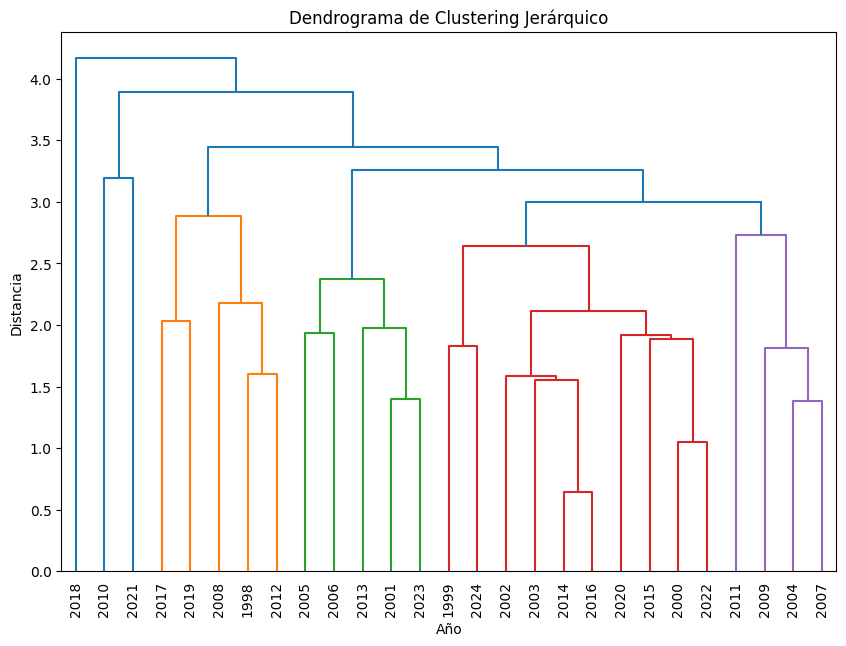

,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5,Cluster6
0,2010.0,2021.0,1998.0,2001.0,1999,2018.0
1,NaN,NaN,2008.0,2005.0,2000,NaN
2,NaN,NaN,2012.0,2006.0,2002,NaN
3,NaN,NaN,2017.0,2013.0,2003,NaN
4,NaN,NaN,2019.0,2023.0,2004,NaN
5,NaN,NaN,NaN,NaN,2007,NaN
6,NaN,NaN,NaN,NaN,2009,NaN
7,NaN,NaN,NaN,NaN,2011,NaN
8,NaN,NaN,NaN,NaN,2014,NaN
9,NaN,NaN,NaN,NaN,2015,NaN


In [101]:

df_scaled = df_atlantico.copy()
#df_scaled.iloc[:, 1:] = (df_scaled.iloc[:, 1:] - df_scaled.iloc[:, 1:].mean()) / df_scaled.iloc[:, 1:].std()

# Calcular la matriz de distancias
dist_matrix = pdist(df_scaled.iloc[:, 1:], metric='euclidean')

# Aplicar el algoritmo de clustering jerárquico
Z = linkage(dist_matrix, method='average')

# Dibujar el dendrograma
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=df_atlantico['Año'].values, leaf_rotation=90)
plt.title('Dendrograma de Clustering Jerárquico')
plt.xlabel('Año')
plt.ylabel('Distancia')
plt.show()



#  criterio para el número máximo de clusters
max_clusters = 6 # máximo de 5 clusters
clusters = fcluster(Z, max_clusters, criterion='maxclust')

df_atlantico['Cluster'] = clusters

df_atlantico[['Año', 'Cluster']]


# Agrupar los años por cada cluster
cluster_groups = df_atlantico.groupby('Cluster')['Año'].apply(list).reset_index()


cluster_results = {}
for index, row in cluster_groups.iterrows():
    cluster_results[f'Cluster{row["Cluster"]}'] = row['Año']

atlantico = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in cluster_results.items()]))


atlantico

### Resultado por el programa de  Infostat (Atlantico) 6 clusters

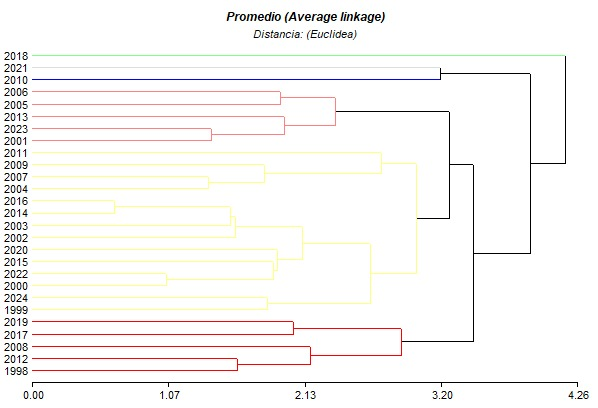

In [103]:
# Transformar tabla para obtener columnas "Año" y "Cluster"
clusters_atlantico = atlantico.melt(var_name='Clusteratlantico', value_name='Año').dropna().reset_index(drop=True)

In [104]:
df_atlantico_clusters = df_atlantico.merge(clusters_atlantico , on='Año', how='left')
df_atlantico_clusters

,Año,Enero,Febrero,Marzo,Abril,Mayo,Junio,Cluster,Clusteratlantico
0,1998,0.39,-0.11,0.87,-0.68,-1.32,-2.72,3,Cluster3
1,1999,0.77,0.29,0.23,-0.95,0.92,1.12,5,Cluster5
2,2000,0.60,1.70,0.77,-0.03,1.58,-0.03,5,Cluster5
3,2001,0.25,0.45,-1.26,0.00,-0.02,-0.20,4,Cluster4
4,2002,0.44,1.10,0.69,1.18,-0.22,0.38,5,Cluster5
5,2003,0.16,0.62,0.32,-0.18,0.01,-0.07,5,Cluster5
6,2004,-0.29,-0.14,1.02,1.15,0.19,-0.89,5,Cluster5
7,2005,1.52,-0.06,-1.83,-0.30,-1.25,-0.05,4,Cluster4
8,2006,1.27,-0.51,-1.28,1.24,-1.14,0.84,4,Cluster4
9,2007,0.22,-0.47,1.44,0.17,0.66,-1.31,5,Cluster5


In [106]:
df_melted = df_atlantico_clusters.melt(id_vars=['Año', 'Clusteratlantico'], 
                           var_name='Mes', 
                           value_name='a_atlantico')
df_melted

,Año,Clusteratlantico,Mes,a_atlantico
0,1998,Cluster3,Enero,0.39
1,1999,Cluster5,Enero,0.77
2,2000,Cluster5,Enero,0.60
3,2001,Cluster4,Enero,0.25
4,2002,Cluster5,Enero,0.44
...,...,...,...,...
184,2020,Cluster5,Cluster,5.00
185,2021,Cluster2,Cluster,2.00
186,2022,Cluster5,Cluster,5.00
187,2023,Cluster4,Cluster,4.00


In [108]:
meses_orden = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio"]
df_melted['Mes'] = pd.Categorical(df_melted['Mes'], categories=meses_orden, ordered=True)

# Graficar la serie de tiempo
fig = px.line(df_melted, x='Mes', y='a_atlantico', color='Clusteratlantico', 
              labels={'Mes': 'Mes', 'a_atlantico': 'Anomalia_atlantico', 'Clusteratlantico': 'Cluster'},
              title='Comportamiento de anomlias atlantico por Cluster')

fig.show()

In [110]:
# Definir el orden de los clusters
clusters_orden = ["Cluster1", "Cluster2", "Cluster3", "Cluster4", "Cluster5", "Cluster6"]
df_melted['Clusteratlantico'] = pd.Categorical(df_melted['Clusteratlantico'], categories=clusters_orden, ordered=True)

# Ordenar los meses
meses_orden = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio"]
df_melted['Mes'] = pd.Categorical(df_melted['Mes'], categories=meses_orden, ordered=True)

# Crear el boxplot
fig = px.box(df_melted, x='Mes', y='a_atlantico', color='Clusteratlantico', 
             labels={'Mes': 'Mes', 'a_atlantico': 'Anomalia_atlantico', 'Clusteratlantico': 'Cluster'},
             title='Comportamiento de anomalias atlantico')

# Mostrar la gráfica
fig.show()

# Caracterización de clusters atlantico  

### Entendimiento 
Las anomalías de temperatura de los océanos se interpretan de la siguiente manera:

* Definición: Una anomalía es la desviación de la temperatura observada respecto a un promedio a largo plazo para esa ubicación y época del año.


Valores:

* Positivos: Indican temperaturas más cálidas que el promedio.
* Negativos: Indican temperaturas más frías que el promedio.
* Cero: Representa temperaturas cercanas al promedio histórico.


Magnitud: Valores más alejados de cero (en ambas direcciones) indican anomalías más fuertes.


* Importancia:

Ayudan a identificar patrones climáticos como El Niño o La Niña.
Son indicadores de cambios climáticos a largo plazo.
Pueden influir en patrones meteorológicos, ecosistemas marinos y ciclos de pesca.

### Clusters
* Cluster 1: 2010
* Cluster 2: 2021
* Cluster 3: 1998,2008,2012,2017,2019
* Cluster 4: 2001,2005,2006,2013,2023
* Cluster 5: 1999,2000,2002,2003,2004,2005,2007,2009,2011,2014,2015,2016,2020,2022,2024
* Cluster 6: 2018

### Interpretación 
* Cluster 5: Es el más grande, abarcando la mayoría de los años desde 1999 hasta 2024. Representa el patrón más común o "normal" de anomalías, con variaciones relativamente pequeñas alrededor de cero.
* Cluster 3 (1998, 2008, 2012, 2017, 2019): Muestra anomalías positivas más pronunciadas, especialmente en los meses de abril a junio. Esto indica años con temperaturas superficiales del Atlántico más cálidas de lo normal.
* Cluster 4 (2001, 2005, 2006, 2013, 2023): Presenta un patrón con anomalías negativas más marcadas en marzo y abril, sugiriendo temperaturas más frías de lo normal en esos meses.
* Cluster 1 (2010): Año único con fuertes anomalias sugiriendo temperaturas más frías de lo normal, se marca un pico de temperaturas mas frias en Febrero
* Cluster 2 (2021): Otro año único con un patrón distinto, mostrando anomalías negativas al principio del año y un fuerte aumento hacia anomalías positivas en mayo y junio.
* Cluster 6 (2018): Presenta un patrón particular con una fuerte anomalía negativa en marzo, indicando un enfriamiento inusual del Atlántico en ese mes.

####################################
# Data pacifico
####################################

In [134]:
df_pacifico= pd.read_excel("D:\\OneDrive - CGIAR\\Proyectos\\AgriLAC-ICC\\Analytics\\Datos para estimación años análogos junio 2024.xlsx", sheet_name="Datos pacífico")
df_pacifico=estructura_df(df_pacifico)
df_pacifico

,Año,Enero,Febrero,Marzo,Abril,Mayo,Junio
0,1998,2.2,1.9,1.4,1.0,0.50,-0.10
1,1999,-1.5,-1.3,-1.1,-1.0,-1.00,-1.00
2,2000,-1.7,-1.4,-1.1,-0.8,-0.70,-0.60
3,2001,-0.7,-0.5,-0.4,-0.3,-0.30,-0.10
4,2002,-0.1,0.0,0.1,0.2,0.40,0.70
5,2003,0.9,0.6,0.4,0.0,-0.30,-0.20
6,2004,0.4,0.3,0.2,0.2,0.20,0.30
7,2005,0.6,0.6,0.4,0.4,0.30,0.10
8,2006,-0.9,-0.8,-0.6,-0.4,-0.10,0.00
9,2007,0.7,0.2,-0.1,-0.3,-0.40,-0.50


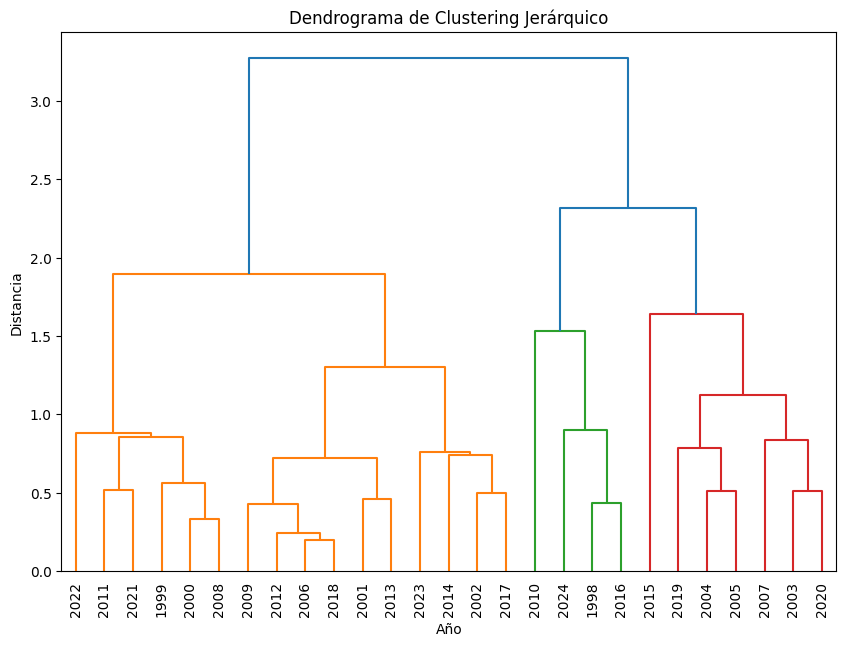

,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5,Cluster6
0,1999.0,2001,1998.0,2010.0,2003.0,2015.0
1,2000.0,2002,2016.0,NaN,2004.0,NaN
2,2008.0,2006,2024.0,NaN,2005.0,NaN
3,2011.0,2009,NaN,NaN,2007.0,NaN
4,2021.0,2012,NaN,NaN,2019.0,NaN
5,2022.0,2013,NaN,NaN,2020.0,NaN
6,NaN,2014,NaN,NaN,NaN,NaN
7,NaN,2017,NaN,NaN,NaN,NaN
8,NaN,2018,NaN,NaN,NaN,NaN
9,NaN,2023,NaN,NaN,NaN,NaN


In [127]:
# Normalizar los datos (opcional, pero recomendable)
df_scaled = df_pacifico.copy()
#df_scaled.iloc[:, 1:] = (df_scaled.iloc[:, 1:] - df_scaled.iloc[:, 1:].mean()) / df_scaled.iloc[:, 1:].std()

# Calcular la matriz de distancias
dist_matrix = pdist(df_scaled.iloc[:, 1:], metric='euclidean')

# Aplicar el algoritmo de clustering jerárquico
Z = linkage(dist_matrix, method='average')

# Dibujar el dendrograma
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=df_pacifico['Año'].values, leaf_rotation=90)
plt.title('Dendrograma de Clustering Jerárquico')
plt.xlabel('Año')
plt.ylabel('Distancia')
plt.show()


#  criterio para el número máximo de clusters
max_clusters = 6  # máximo de clusters
clusters = fcluster(Z, max_clusters, criterion='maxclust')

df_pacifico['Cluster'] = clusters

df_pacifico[['Año', 'Cluster']]


# Agrupar los años por cada cluster
cluster_groups = df_pacifico.groupby('Cluster')['Año'].apply(list).reset_index()


cluster_results = {}
for index, row in cluster_groups.iterrows():
    cluster_results[f'Cluster{row["Cluster"]}'] = row['Año']

pacifico = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in cluster_results.items()]))

pacifico

### Resultado por el programa de  Infostat

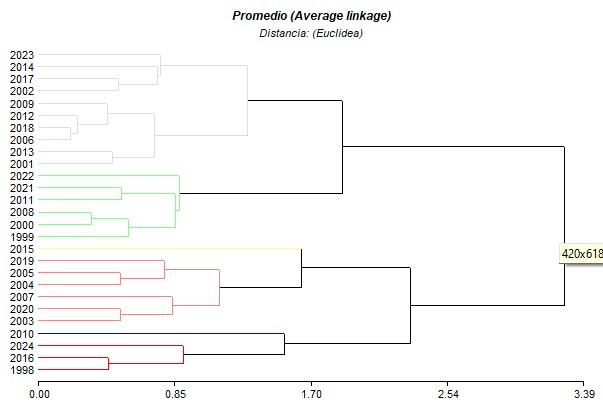

In [121]:
# Transformar tabla para obtener columnas "Año" y "Cluster"
clusters_pacifico = pacifico.melt(var_name='ClusterPacifico', value_name='Año').dropna().reset_index(drop=True)
clusters_pacifico

,ClusterPacifico,Año
0,Cluster1,1999.0
1,Cluster1,2000.0
2,Cluster1,2008.0
3,Cluster1,2011.0
4,Cluster1,2021.0
5,Cluster1,2022.0
6,Cluster2,2001.0
7,Cluster2,2002.0
8,Cluster2,2006.0
9,Cluster2,2009.0


In [135]:
#### tabla formato largo
df_melted = df_pacifico.melt(id_vars='Año', var_name='Mes', value_name='a_pacifico')
df_melted

,Año,Mes,a_pacifico
0,1998,Enero,2.20
1,1999,Enero,-1.50
2,2000,Enero,-1.70
3,2001,Enero,-0.70
4,2002,Enero,-0.10
...,...,...,...
157,2020,Junio,-0.30
158,2021,Junio,-0.40
159,2022,Junio,-0.90
160,2023,Junio,0.80


In [136]:

meses_orden = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio"]
df_melted['Mes'] = pd.Categorical(df_melted['Mes'], categories=meses_orden, ordered=True)

# Graficar la serie de tiempo
fig = px.line(df_melted, x='Mes', y='a_pacifico', color='Año',
              labels={'Mes': 'Mes', 'a_pacifico': 'anomalia', 'Año': 'Año'},
              title='Comportamiento de anomalia temperatura oceano pacifico')

fig.show()

In [137]:
df_pacifico_clusters = df_pacifico.merge(clusters_pacifico, on='Año', how='left')
df_pacifico_clusters

,Año,Enero,Febrero,Marzo,Abril,Mayo,Junio,ClusterPacifico
0,1998,2.2,1.9,1.4,1.0,0.50,-0.10,Cluster3
1,1999,-1.5,-1.3,-1.1,-1.0,-1.00,-1.00,Cluster1
2,2000,-1.7,-1.4,-1.1,-0.8,-0.70,-0.60,Cluster1
3,2001,-0.7,-0.5,-0.4,-0.3,-0.30,-0.10,Cluster2
4,2002,-0.1,0.0,0.1,0.2,0.40,0.70,Cluster2
5,2003,0.9,0.6,0.4,0.0,-0.30,-0.20,Cluster5
6,2004,0.4,0.3,0.2,0.2,0.20,0.30,Cluster5
7,2005,0.6,0.6,0.4,0.4,0.30,0.10,Cluster5
8,2006,-0.9,-0.8,-0.6,-0.4,-0.10,0.00,Cluster2
9,2007,0.7,0.2,-0.1,-0.3,-0.40,-0.50,Cluster5


In [138]:
df_melted = df_pacifico_clusters.melt(id_vars=['Año', 'ClusterPacifico'], 
                           var_name='Mes', 
                           value_name='a_pacifico')
df_melted

,Año,ClusterPacifico,Mes,a_pacifico
0,1998,Cluster3,Enero,2.20
1,1999,Cluster1,Enero,-1.50
2,2000,Cluster1,Enero,-1.70
3,2001,Cluster2,Enero,-0.70
4,2002,Cluster2,Enero,-0.10
...,...,...,...,...
157,2020,Cluster5,Junio,-0.30
158,2021,Cluster1,Junio,-0.40
159,2022,Cluster1,Junio,-0.90
160,2023,Cluster2,Junio,0.80


In [139]:
meses_orden = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio"]
df_melted['Mes'] = pd.Categorical(df_melted['Mes'], categories=meses_orden, ordered=True)

# Graficar la serie de tiempo
fig = px.line(df_melted, x='Mes', y='a_pacifico', color='ClusterPacifico', 
              labels={'Mes': 'Mes', 'a_pacifico': 'Anomalia_pacifico', 'a_pacifico': 'Cluster'},
              title='Comportamiento de anomlias pacifico por Cluster')

fig.show()

In [141]:
meses_orden = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio"]
df_melted['Mes'] = pd.Categorical(df_melted['Mes'], categories=meses_orden, ordered=True)

# Graficar la serie de tiempo
fig = px.box(df_melted, x='Mes', y='a_pacifico', color='ClusterPacifico', 
              labels={'Mes': 'Mes', 'a_pacifico': 'anomalia pacifico', 'ClusterPacifico': 'Cluster'},
              title='Comportamiento de anomalias pacifico por Cluster')

fig.show()

# Caracterización de clusters pacifico

### Entendimiento 
Las anomalías de temperatura de los océanos se interpretan de la siguiente manera:

* Definición: Una anomalía es la desviación de la temperatura observada respecto a un promedio a largo plazo para esa ubicación y época del año.


Valores:

* Positivos: Indican temperaturas más cálidas que el promedio.
* Negativos: Indican temperaturas más frías que el promedio.
* Cero: Representa temperaturas cercanas al promedio histórico.


Magnitud: Valores más alejados de cero (en ambas direcciones) indican anomalías más fuertes.


* Importancia:

Ayudan a identificar patrones climáticos como El Niño o La Niña.
Son indicadores de cambios climáticos a largo plazo.
Pueden influir en patrones meteorológicos, ecosistemas marinos y ciclos de pesca.

### Clusters
* Cluster 1: 1999,2000,2008,2011,2021,2022
* Cluster 2: 2001,2002,2006,2009,2012,2013,2014,2017,2018,2023
* Cluster 3: 1998, 2016,2024 
* Cluster 4: 2010
* Cluster 5: 2003,2004,2005,2007,2019,2020
* Cluster 6: 2015

### Interpretación 
* Cluster 1: Este grupo muestra anomalías mayormente negativas durante todo el año, con una ligera tendencia al calentamiento hacia junio. Estos años probablemente representan condiciones de La Niña leve o neutras.
* Cluster 2: Este cluster exhibe condiciones casi neutrales, con anomalías cercanas a cero. Hay una ligera tendencia al calentamiento de enero a junio.
* Cluster 3: Este grupo muestra fuertes anomalías positivas durante todo el período, particularmente en los primeros meses. Estos años probablemente representan condiciones fuertes de El Niño.
* Cluster 4: Este año único muestra un patrón singular con anomalías positivas muy altas, especialmente de enero a abril, sugiriendo un evento de El Niño excepcionalmente fuerte.
* Cluster 5: Este cluster muestra anomalías ligeramente positivas, con más variabilidad que el Cluster 2. Estos podrían representar condiciones de El Niño débiles a moderadas.
* Cluster 6: Otro cluster de un solo año, que muestra anomalías moderadamente positivas que aumentan hacia junio. Esto probablemente representa el desarrollo de un evento significativo de El Niño.

###############################################################################
# Ponderación de clusters - ICC
###############################################################################

\begin{equation}
Z = M_1 + M_2 + M_3
\end{equation}

\begin{equation}
M = (N - n) \times p
\end{equation}

* M: Factor de ponderación.
* N: Cantidad de eventos.
* n: Posición con respecto al año actual (2024).
* p: Peso.

Peso de las variables
* Lluvia (L): p = 0.4
* Atlántico (A): p = 0.25
* Pacífico (P): p = 0.35


In [10]:
lluvia = lluvia.melt(var_name='ClusterLluvia', value_name='Año').dropna().set_index('Año')
atlantico = atlantico.melt(var_name='ClusterAtlantico', value_name='Año').dropna().set_index('Año')
pacifico = pacifico.melt(var_name='ClusterPacifico', value_name='Año').dropna().set_index('Año')


In [13]:
df_combined = lluvia.join(atlantico, how='outer').join(pacifico, how='outer').reset_index()
df_combined = df_combined.fillna('NaN')

In [14]:
df_combined

,Año,ClusterLluvia,ClusterAtlantico,ClusterPacifico
0,1998.0,Cluster4,Cluster3,Cluster3
1,1999.0,Cluster1,Cluster5,Cluster1
2,2000.0,Cluster1,Cluster5,Cluster1
3,2001.0,Cluster1,Cluster4,Cluster2
4,2002.0,Cluster1,Cluster5,Cluster2
5,2003.0,Cluster5,Cluster5,Cluster5
6,2004.0,Cluster2,Cluster5,Cluster5
7,2005.0,Cluster6,Cluster4,Cluster5
8,2006.0,Cluster1,Cluster4,Cluster2
9,2007.0,Cluster1,Cluster5,Cluster5


In [15]:
# Definir los pesos
peso_lluvia = 0.4
peso_atlantico = 0.25
peso_pacifico = 0.35

In [18]:
# Cantidad de eventos
N = len(df_combined)
N

27

In [19]:
# Calcular el factor de ponderación
df_combined['n'] = 2024 - df_combined['Año']
df_combined['M_lluvia'] = (N - df_combined['n']) * peso_lluvia
df_combined['M_atlantico'] = (N - df_combined['n']) * peso_atlantico
df_combined['M_pacifico'] = (N - df_combined['n']) * peso_pacifico

In [20]:
df_combined['Z'] = df_combined['M_lluvia'] + df_combined['M_atlantico'] + df_combined['M_pacifico']

In [21]:
df_combined = df_combined.sort_values(by='Z', ascending=False)

In [22]:
df_combined


,Año,ClusterLluvia,ClusterAtlantico,ClusterPacifico,n,M_lluvia,M_atlantico,M_pacifico,Z
26,2024.0,Cluster1,Cluster5,Cluster3,0.0,10.8,6.75,9.45,27.0
25,2023.0,Cluster1,Cluster4,Cluster2,1.0,10.4,6.50,9.10,26.0
24,2022.0,Cluster1,Cluster5,Cluster1,2.0,10.0,6.25,8.75,25.0
23,2021.0,Cluster1,Cluster2,Cluster1,3.0,9.6,6.00,8.40,24.0
22,2020.0,Cluster1,Cluster5,Cluster5,4.0,9.2,5.75,8.05,23.0
21,2019.0,Cluster1,Cluster3,Cluster5,5.0,8.8,5.50,7.70,22.0
20,2018.0,Cluster1,Cluster6,Cluster2,6.0,8.4,5.25,7.35,21.0
19,2017.0,Cluster1,Cluster3,Cluster2,7.0,8.0,5.00,7.00,20.0
18,2016.0,Cluster1,Cluster5,Cluster3,8.0,7.6,4.75,6.65,19.0
17,2015.0,Cluster1,Cluster5,Cluster6,9.0,7.2,4.50,6.30,18.0


### Clasificacion final

In [27]:
# Aplicar clustering jerárquico
Z = linkage(df_combined['Z'].values.reshape(-1, 1), method='ward')
max_clusters = 6
clusters = fcluster(Z, max_clusters, criterion='maxclust')

df_combined['Cluster'] = clusters

# Agrupar los años por cada clúster
cluster_groups = df_combined.groupby('Cluster')['Año'].apply(list).reset_index()

# Crear un diccionario con los resultados de los clústeres
cluster_results = {}
for index, row in cluster_groups.iterrows():
    cluster_results[f'Cluster{row["Cluster"]}'] = row['Año']

final_clusters = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in cluster_results.items()]))


final_clusters

,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5,Cluster6
0,2008.0,2004.0,2024.0,2020.0,2016.0,2012.0
1,2007.0,2003.0,2023.0,2019.0,2015.0,2011.0
2,2006.0,2002.0,2022.0,2018.0,2014.0,2010.0
3,2005.0,2001.0,2021.0,2017.0,2013.0,2009.0
4,NaN,2000.0,NaN,NaN,NaN,NaN
5,NaN,1999.0,NaN,NaN,NaN,NaN
6,NaN,1998.0,NaN,NaN,NaN,NaN


## Segunda parte

Para la segunda parte, se probarán otros métodos de conglomerados con el objetivo de realizar una clasificación de periodos agrupando las tres variables. Además, se procederá a normalizar los datos. Normalizar los datos es una práctica fundamental antes de aplicar cualquier método de análisis, y en este caso, es especialmente crucial. Dado que se realizará el análisis de conglomerados utilizando las tres variables, la estandarización de los datos es esencial para garantizar que cada variable contribuya de manera equitativa al proceso de agrupamiento.

### Unir las tres bases de datos

In [73]:
df = pd.merge(df_atlantico, df_pacifico, on='Año', suffixes=('_atlantico', '_pacifico'))


In [74]:
df = pd.merge(df, df_lluvia, on='Año', suffixes=('', '_lluvia'))

In [77]:
columns_to_rename = {
    'Enero': 'Enero_lluvia',
    'Febrero': 'Febrero_lluvia',
    'Marzo': 'Marzo_lluvia',
    'Abril': 'Abril_lluvia',
    'Mayo': 'Mayo_lluvia',
    'Junio': 'Junio_lluvia'
}

df.rename(columns=columns_to_rename, inplace=True)
df

,Año,Enero_atlantico,Febrero_atlantico,Marzo_atlantico,Abril_atlantico,Mayo_atlantico,Junio_atlantico,Cluster,Enero_pacifico,Febrero_pacifico,Marzo_pacifico,Abril_pacifico,Mayo_pacifico,Junio_pacifico,Enero_lluvia,Febrero_lluvia,Marzo_lluvia,Abril_lluvia,Mayo_lluvia,Junio_lluvia
0,1998,0.39,-0.11,0.87,-0.68,-1.32,-2.72,1,2.2,1.9,1.4,1.0,0.50,-0.10,0.0,0.0,0.0,4.8,23.8,84.8
1,1999,0.77,0.29,0.23,-0.95,0.92,1.12,2,-1.5,-1.3,-1.1,-1.0,-1.00,-1.00,0.4,49.6,47.8,294.0,494.2,662.4
2,2000,0.60,1.70,0.77,-0.03,1.58,-0.03,1,-1.7,-1.4,-1.1,-0.8,-0.70,-0.60,12.0,12.0,7.4,21.4,319.4,405.4
3,2001,0.25,0.45,-1.26,0.00,-0.02,-0.20,2,-0.7,-0.5,-0.4,-0.3,-0.30,-0.10,1.4,68.0,25.2,91.8,501.8,633.8
4,2002,0.44,1.10,0.69,1.18,-0.22,0.38,1,-0.1,0.0,0.1,0.2,0.40,0.70,27.0,6.8,44.4,46.8,389.0,425.5
5,2003,0.16,0.62,0.32,-0.18,0.01,-0.07,1,0.9,0.6,0.4,0.0,-0.30,-0.20,0.0,39.7,85.6,283.3,1260.8,1122.0
6,2004,-0.29,-0.14,1.02,1.15,0.19,-0.89,1,0.4,0.3,0.2,0.2,0.20,0.30,12.0,24.6,108.4,70.9,757.6,505.8
7,2005,1.52,-0.06,-1.83,-0.30,-1.25,-0.05,2,0.6,0.6,0.4,0.4,0.30,0.10,34.0,1.8,60.0,162.2,581.0,1290.8
8,2006,1.27,-0.51,-1.28,1.24,-1.14,0.84,2,-0.9,-0.8,-0.6,-0.4,-0.10,0.00,23.7,0.0,0.0,196.0,433.0,289.3
9,2007,0.22,-0.47,1.44,0.17,0.66,-1.31,1,0.7,0.2,-0.1,-0.3,-0.40,-0.50,0.0,18.0,44.2,265.2,484.8,587.4


### Se aplica el método de cluster jerarquico teniendo en cuenta las tres variables 

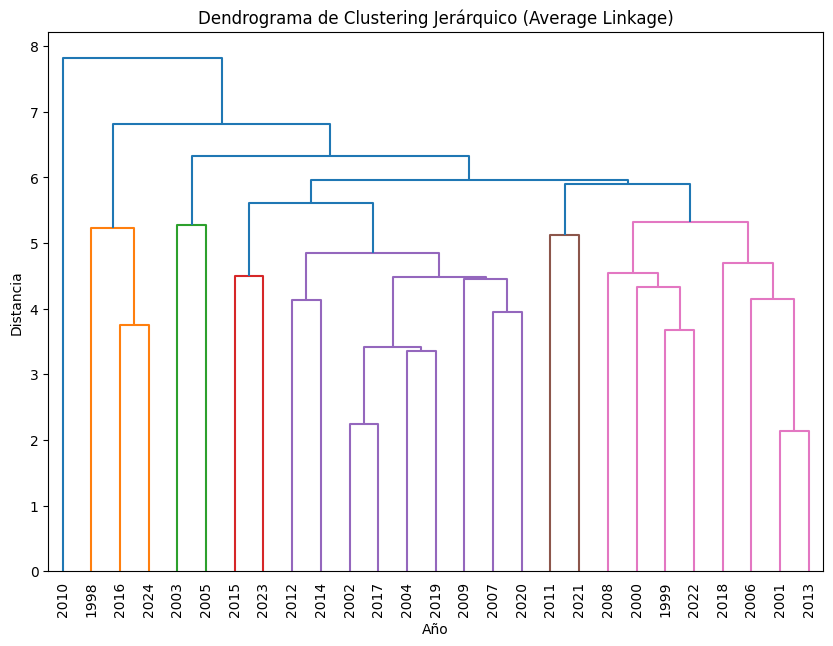

,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5,Cluster6
0,1998,2003,2002,2011,1999,2010
1,2016,2005,2004,2021,2000,NaN
2,2024,NaN,2007,NaN,2001,NaN
3,NaN,NaN,2009,NaN,2006,NaN
4,NaN,NaN,2012,NaN,2008,NaN
5,NaN,NaN,2014,NaN,2013,NaN
6,NaN,NaN,2015,NaN,2018,NaN
7,NaN,NaN,2017,NaN,2022,NaN
8,NaN,NaN,2019,NaN,NaN,NaN
9,NaN,NaN,2020,NaN,NaN,NaN


In [165]:
# columnas a normalizar

df_st= df.copy()
df_st['Año']= df_st['Año'].astype('string')

columns_to_normalize = df_st.columns.difference(['Año'])

# Normalizar las columnas
df_st[columns_to_normalize] = (df_st[columns_to_normalize] - df_st[columns_to_normalize].mean()) / df_st[columns_to_normalize].std()

#scaler = StandardScaler()
#data_normalized = scaler.fit_transform(df.drop(columns=['Año']))

# matriz de distancias
dist_matrix = pdist(df_st[columns_to_normalize], metric='euclidean')

# algoritmo de clustering jerárquico usando Average Linkage
Z = linkage(dist_matrix, method='average')

# dendrograma
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=df_st['Año'].values, leaf_rotation=90)
plt.title('Dendrograma de Clustering Jerárquico (Average Linkage)')
plt.xlabel('Año')
plt.ylabel('Distancia')
plt.show()


#  criterio para el número máximo de clusters
max_clusters = 6  # máximo de clusters
clusters = fcluster(Z, max_clusters, criterion='maxclust')

df_st['Cluster'] = clusters

df_st[['Año', 'Cluster']]


# Agrupar los años por cada cluster
cluster_groups = df_st.groupby('Cluster')['Año'].apply(list).reset_index()


cluster_results = {}
for index, row in cluster_groups.iterrows():
    cluster_results[f'Cluster{row["Cluster"]}'] = row['Año']

cluster_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in cluster_results.items()]))


cluster_df

### Método DBSCAN

no resultó ser un buen método para clasificar los periodos


Mejores parámetros:  {'eps': 0.1, 'min_samples': 2}
     Año  Cluster_DBSCAN
0   1998              -1
1   1999              -1
2   2000              -1
3   2001              -1
4   2002              -1
5   2003              -1
6   2004              -1
7   2005              -1
8   2006              -1
9   2007              -1
10  2008              -1
11  2009              -1
12  2010              -1
13  2011              -1
14  2012              -1
15  2013              -1
16  2014              -1
17  2015              -1
18  2016              -1
19  2017              -1
20  2018              -1
21  2019              -1
22  2020              -1
23  2021              -1
24  2022              -1
25  2023              -1
26  2024              -1


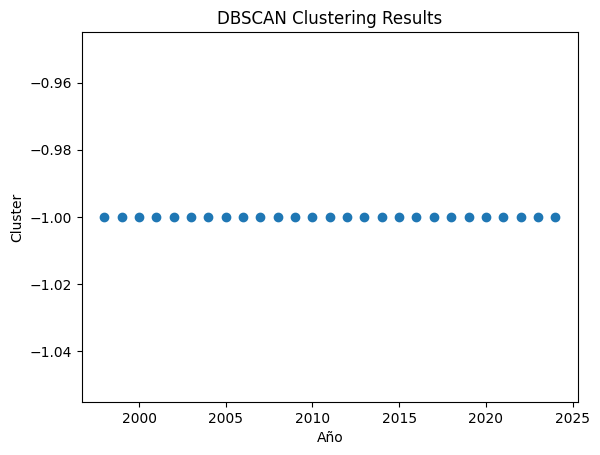

In [151]:

df_st = df.copy()
df_st['Año'] = df_st['Año'].astype('string')

# Seleccionar las columnas a normalizar (todas menos 'Año')
columns_to_normalize = df_st.columns.difference(['Año'])

# Normalizar las columnas
scaler = StandardScaler()
df_st[columns_to_normalize] = scaler.fit_transform(df_st[columns_to_normalize])

# Crear una clase envoltorio para DBSCAN para usar con GridSearchCV
class DBSCANWrapper(BaseEstimator, ClusterMixin):
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples
        self.dbscan = DBSCAN(eps=self.eps, min_samples=self.min_samples)

    def fit(self, X, y=None):
        self.dbscan.set_params(eps=self.eps, min_samples=self.min_samples)
        self.dbscan.fit(X)
        return self

    def fit_predict(self, X, y=None):
        self.fit(X)
        return self.dbscan.labels_

# Definir el grid de parámetros
param_grid = {
    'eps': np.arange(0.1, 2.0, 0.1),
    'min_samples': np.arange(2, 10)
}

# Definir la función de scoring
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    if len(set(labels)) > 1:
        return silhouette_score(X, labels)
    else:
        return -1  # Si sólo hay un clúster, la puntuación es no válida

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(DBSCANWrapper(), param_grid, scoring=make_scorer(silhouette_scorer), cv=3)

# Realizar la búsqueda en malla
grid_search.fit(df_st[columns_to_normalize])

# Obtener los mejores parámetros
best_params = grid_search.best_params_
print("Mejores parámetros: ", best_params)

# Aplicar DBSCAN con los mejores parámetros
dbscan = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
df_st['Cluster_DBSCAN'] = dbscan.fit_predict(df_st[columns_to_normalize])

# Verificar los clústeres asignados
print(df_st[['Año', 'Cluster_DBSCAN']])

# Visualizar los resultados (opcional)
plt.scatter(df_st['Año'].astype(int), df_st['Cluster_DBSCAN'])
plt.title('DBSCAN Clustering Results')
plt.xlabel('Año')
plt.ylabel('Cluster')
plt.show()

### Método de kmeans

In [169]:
df_st = df.copy()
df_st['Año'] = df_st['Año'].astype('string')


columns_to_normalize = df_st.columns.difference(['Año'])

scaler = StandardScaler()
df_st[columns_to_normalize] = scaler.fit_transform(df_st[columns_to_normalize])


kmeans = KMeans(n_clusters=6, random_state=42)
df_st['Cluster_KMeans'] = kmeans.fit_predict(df_st[columns_to_normalize])

# Crear un DataFrame vacío para los resultados
df_result = pd.DataFrame(index=range(max(df_st['Cluster_KMeans'].value_counts())), 
                         columns=[f'Cluster{i+1}' for i in range(6)])

# Iterar sobre cada clúster y asignar los años
for cluster in range(6):
    years = df_st[df_st['Cluster_KMeans'] == cluster]['Año'].values
    df_result[f'Cluster{cluster + 1}'][:len(years)] = sorted(years)

# Mostrar el DataFrame final
df_result

,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5,Cluster6
0,2008,2010,1999,2001,1998,2004
1,2012,2016,2000,2003,2002,2007
2,NaN,2024,2006,2005,2015,2009
3,NaN,NaN,2013,2014,2017,2011
4,NaN,NaN,2018,2020,2019,2023
5,NaN,NaN,2021,NaN,NaN,NaN
6,NaN,NaN,2022,NaN,NaN,NaN
